In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from constants import n_u_0
from posterior_inference import *
from scipy.interpolate import interp1d
import tqdm

# Compute $p_\gamma$ over $(\langle \sigma v \rangle, m_{\mathrm{DM}})$ grid for fixed $M_{\mathrm{PBH}}$

In [2]:
m_pbh = 0.5
n_pbh = 1

In [3]:
# Make table
m_dms = np.logspace(1, 4, 3)
svs = np.logspace(-45, -25, 15)
save_p_gamma_table(m_pbh, m_dms, svs, n_samples=100000)

In [3]:
# Load table
svs, m_dms, p_gamma, p_gamma_err = load_p_gamma(m_pbh)
m_dm_mg, sv_mg = np.meshgrid(m_dms, svs)

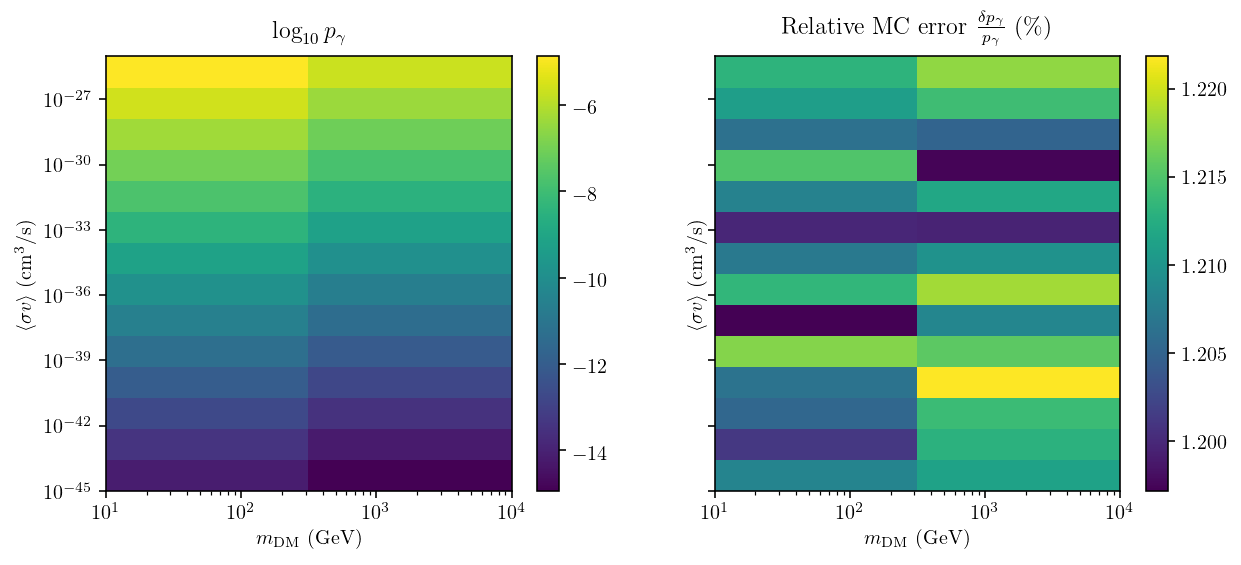

In [6]:
# Make sure errors are small
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

for ax in axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
    ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")

ax = axes[0]
ax.set_title(r"$\log_{10} p_\gamma$")
img_vals = ax.pcolormesh(m_dm_mg, sv_mg, np.log10(p_gamma(sv_mg, m_dm_mg)))
plt.colorbar(img_vals, ax=ax)

ax = axes[1]
ax.set_title(r"Relative MC error $\frac{\delta p_\gamma}{p_\gamma}$ (\%)")
img_rel_errs = ax.pcolormesh(
    m_dm_mg, sv_mg, (p_gamma_err(sv_mg, m_dm_mg) / p_gamma(sv_mg, m_dm_mg) * 100))
plt.colorbar(img_rel_errs, ax=ax)

# $p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, N_U)$

The point of these cells is to figure out what $\langle \sigma v \rangle$ grid to use for different values of $N_{\mathrm{PBH}}$.
* $(M, N) = (0.5~M_\odot,~1)$: $\log_{10}\langle \sigma v \rangle = -42,..., -26$
* $(M, N) = (0.5~M_\odot,~72)$: ???

In [2]:
m_pbh = 0.5
n_pbh = 82

In [3]:
# # Make p_gamma table
# m_dms = np.logspace(1, 4, 3)
# svs = np.logspace(-45, -25, 15)
# save_p_gamma_table(m_pbh, m_dms, svs, n_samples=100000)

In [4]:
# Load p_gamma table
svs, m_dms, p_gamma, p_gamma_err = load_p_gamma(m_pbh)
m_dm_mg, sv_mg = np.meshgrid(m_dms, svs)

In [5]:
# Loads p(f|N_PBH) for GW experiments, computed by Bradley.
# The third argument specifies the directory containing the
# posterior data files.
p_f = load_p_f_gw(m_pbh, n_pbh)

In [9]:
m_dms = np.logspace(1, 4, 3)
svs = np.logspace(-45, -25, 3)
m_dm_mg, sv_mg = np.meshgrid(m_dms, svs)

post_vals = get_posterior_val(sv_mg, n_pbh, p_f, p_gamma, m_pbh, m_dm_mg, n_u_0, "LF", "LF", "U", "trapz")

(1e-45, 1e-25)

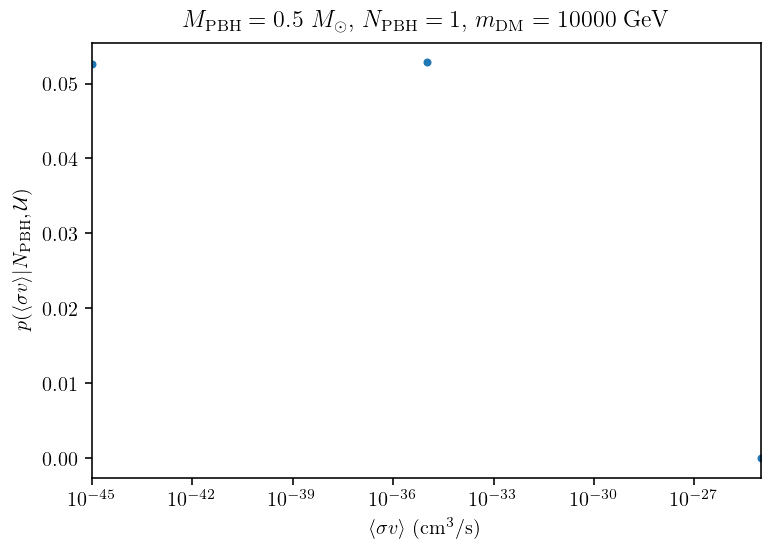

In [10]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[:, -1], '.')

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.title((r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = 1$, "
           r"$m_{\mathrm{DM}} = %i$ GeV") % (m_pbh, m_dms[-1]), fontsize=12)
plt.xlim(svs[[0, -1]])

# Checking posterior integrand/summand
In this section I check the values of the posterior integrand to make sure it isn't too pathological. It can be very sharply peaked (though still fairly broad in log space). I made the function `get_f_samples()` to make sure `quad` adequately samples near this peak.

It looks like the previous naive calls to `quad` were working reasonably well!

In [2]:
m_pbh = 0.5
n_pbh = 1
m_dm = 10
sv = 1e-45

In [3]:
# Make p_gamma table
# m_dms = np.logspace(1, 4, 3)
# svs = np.logspace(-45, -25, 15)
# save_p_gamma_table(m_pbh, m_dms, svs, n_samples=100000)

In [4]:
# Load p_gamma table
svs, m_dms, p_gamma, p_gamma_err = load_p_gamma(m_pbh)
m_dm_mg, sv_mg = np.meshgrid(m_dms, svs)

In [5]:
# Loads p(f|N_PBH) for GW experiments, computed by Bradley.
# The third argument specifies the directory containing the
# posterior data files.
p_f = load_p_f_gw(m_pbh, n_pbh)

In [11]:
# Evaluate posterior integrand
fs = np.logspace(-6, 0, 100)
n_gs = np.arange(0, n_u_0+1)
n_g_mg_init, f_mg_init = np.meshgrid(n_gs, fs)

integrand_vals_init = posterior_integrand(sv, n_g_mg_init, f_mg_init, n_pbh, p_f, p_gamma,
                                          m_pbh, m_dm, n_u_0, "LF", "LF", "U")

In [12]:
n_peak = 250
n_low = 30
n_high = 200

integrand_max = integrand_vals_init.max(axis=0)
min_sample_val = 0.1 * integrand_max
d = (np.sign(min_sample_val - integrand_vals_init[:-1]) -
     np.sign(min_sample_val - integrand_vals_init[1:]))

f_low = fs[np.argmax(d > 0, axis=0)]

idx_high = np.argmax(d < 0, axis=0)
idx_high[idx_high == 0] = -1
f_high = fs[idx_high]

f_mg = np.zeros([n_low + n_peak + n_high, integrand_vals_init.shape[1]])
for i in range(integrand_vals_init.shape[1]):
    n_peak_cur = n_peak
    f_samples_low = np.array([])
    f_samples_high = np.array([])
    if f_low[i] == fs[0]:
        n_peak_cur += n_low
    else:
        f_samples_low = np.geomspace(fs[0], f_low[i], n_low)
    if f_high[i] == fs[-1]:
        n_peak_cur += n_high
    else:
        f_samples_high = np.geomspace(f_high[i], fs[-1], n_high)
    f_samples_peak = np.geomspace(f_low[i], f_high[i], n_peak_cur)
    f_mg[:, i] = np.concatenate([f_samples_low, f_samples_peak, f_samples_high])
n_g_mg = n_gs * np.ones_like(f_mg)

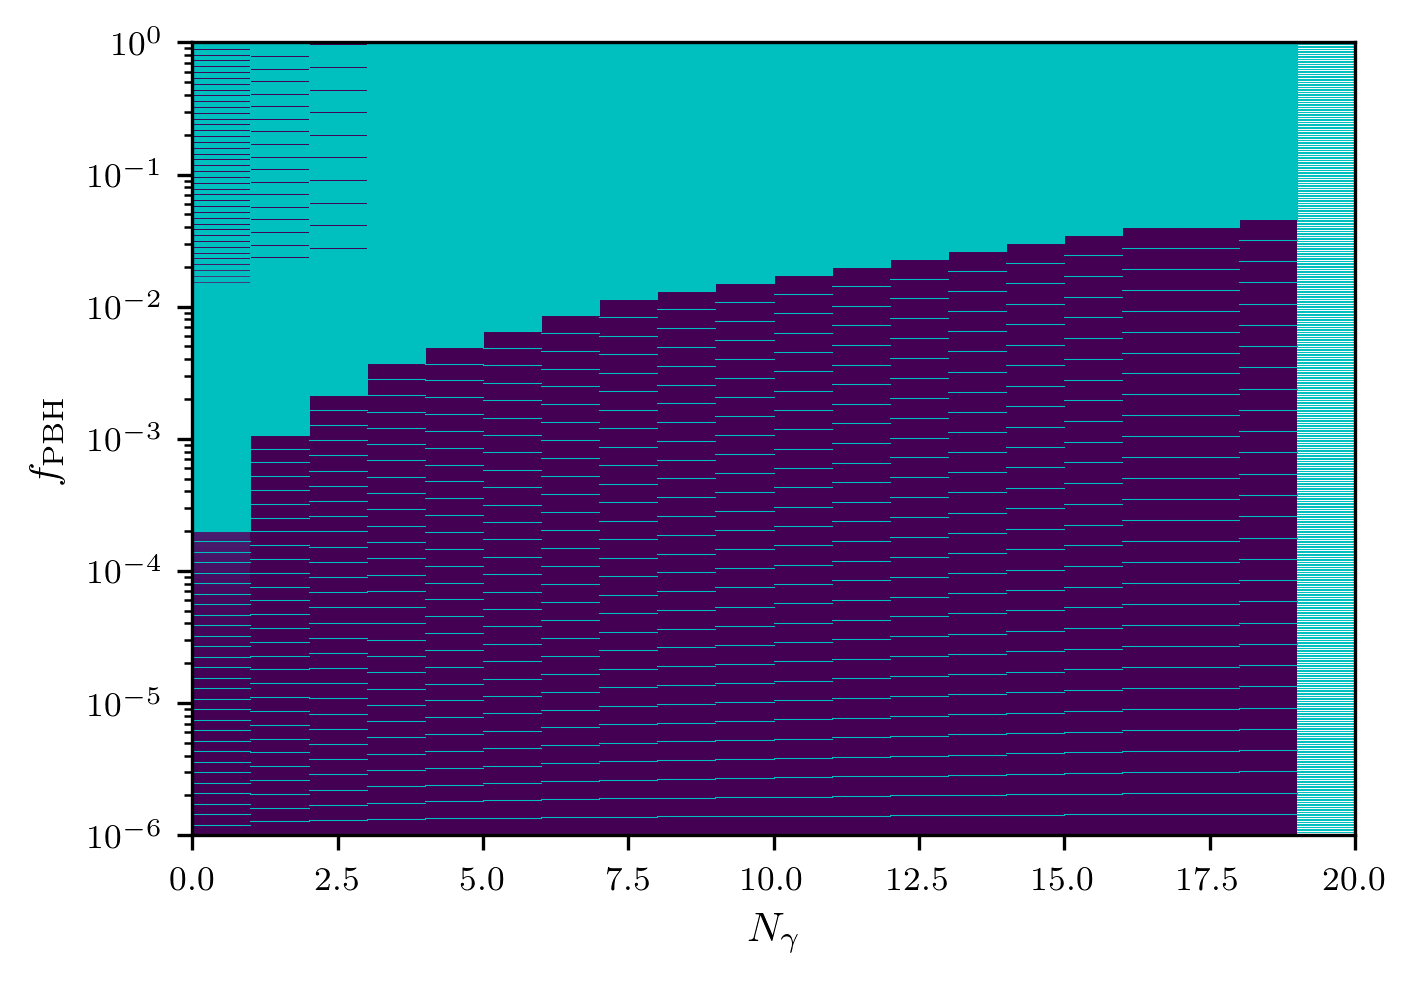

In [14]:
plt.yscale("log")
plt.xlabel(r"$N_\gamma$")
plt.ylabel(r"$f_{\mathrm{PBH}}$")
plt.xlim(0, n_gs.max()+1)
plt.ylim(fs[[0, -1]])
plt.pcolormesh(n_g_mg_init, f_mg_init, integrand_vals_init)

for i, (n_g, f_vals) in enumerate(zip(n_gs, f_mg.T)):
    for f in f_vals:
        plt.plot([n_g, n_g+1], 2*[f], 'c', linewidth=0.25)

Way faster to use `trapz` with this sampling scheme than to use `quad`

In [6]:
get_posterior_val(sv, n_pbh, p_f, p_gamma, m_pbh, m_dm, n_u_0, "LF", "LF", "U", "trapz")

array(0.05268243)

In [7]:
get_posterior_val(sv, n_pbh, p_f, p_gamma, m_pbh, m_dm, n_u_0, "LF", "LF", "U", "quad")

/Users/acoogan/Dropbox/Physics/Black holes/pbhs_vs_wimps/posterior_inference.py:334: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrand, f_min, f_max, points=points_f, epsabs=1e-99)[0]


array(0.05267492)

In [65]:
os.system("say 'done'")

0

# Developing script for the cluster

Should make two parts of the script:
* One to generate the `p_gamma` tables. This should take `m_pbh` as a command line argument and create a file in the `data/` directory. Optional arguments:
    * `n_samples`: number of MC samples
    * `m_dm_min`, `m_dm_max`, `n_m_dms`: parameters controlling range and number of DM masses
    * `sv_min`, `sv_max`, `n_svs`: parameters controlling range and number of cross sections
* Another to generate tables of the posterior for $\langle \sigma v \rangle$ given `m_pbh` and `n_pbh`. This should take `m_pbh` and `n_pbh` as arguments. The posterior will be computed at the values of `m_dm` and `sv` from the relevant `p_gamma` table.

In [6]:
np.linspace(0.2, 1., 9)

array([ 0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. , 10. ])

## Finding a good range for `sv`

Make sure `sv` range works for `m_pbh` between 0.2 and 1, as well as 10.
* `np.log10(svs) = -45, ..., -25`

This cell loads the $p_\gamma$ table if it exists, or creates and loads it if it doesn't.

In [22]:
m_pbh = 0.2
n_pbh = 10  # number of detected PBHs

print("Creating p_gamma table")
m_dms = np.logspace(1, 4, 2)
svs = np.logspace(-45, -25, 10)
save_p_gamma_table(m_pbh, m_dms, svs, n_samples=100000)
m_dms, svs, p_gamma = load_p_gamma(m_pbh)
print("Loaded p_gamma table")

Creating p_gamma table
Loaded p_gamma table


This cell loads $p(f|N_{\mathrm{PBH}})$

In [23]:
# Loads p(f|N_PBH) for GW experiments, computed by Bradley.
# The third argument specifies the directory containing the
# posterior data files.
p_f = load_p_f_gw(m_pbh, n_pbh)

In [24]:
save_posterior_table(svs, n_pbh, p_f, p_gamma, m_pbh, m_dms)

In [25]:
m_dms, svs, post_vals = load_posterior(m_pbh, n_pbh)

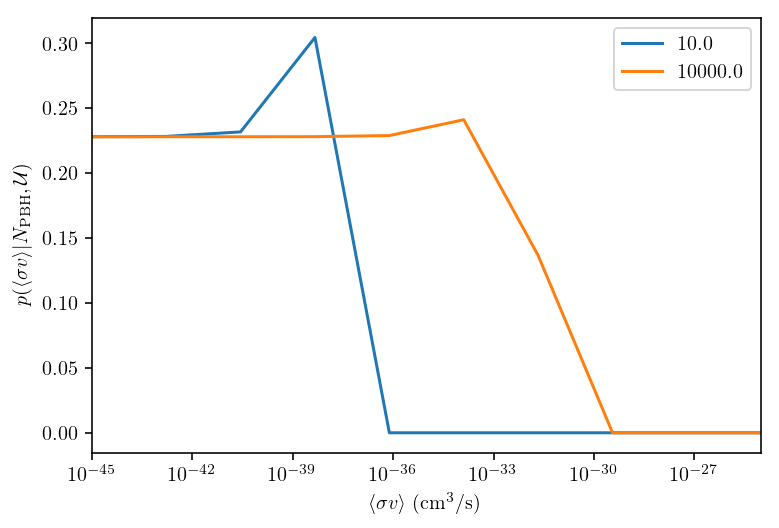

In [26]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[0], label=m_dms[0])
plt.plot(svs, post_vals[-1], label=m_dms[-1])

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
# plt.title((r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = 1$, "
#            r"$m_{\mathrm{DM}} = %i$ GeV") % (m_pbh, m_dms[0]), fontsize=12)
plt.xlim(svs[[0, -1]])
plt.legend()

In [17]:
os.system("say 'Done'")

0

In [28]:
# Evaluate posterior over a grid of <sigma v> and m_DM values
sv_mg, m_dm_mg = np.meshgrid(svs, m_dms)

# This array satisfies
#    post_vals[i, j] = p(m_dms[i], svs[j]).
post_vals = get_posterior_val(sv_mg, n_pbh, n_u_0, p_f, p_gamma, m_pbh, m_dm_mg)

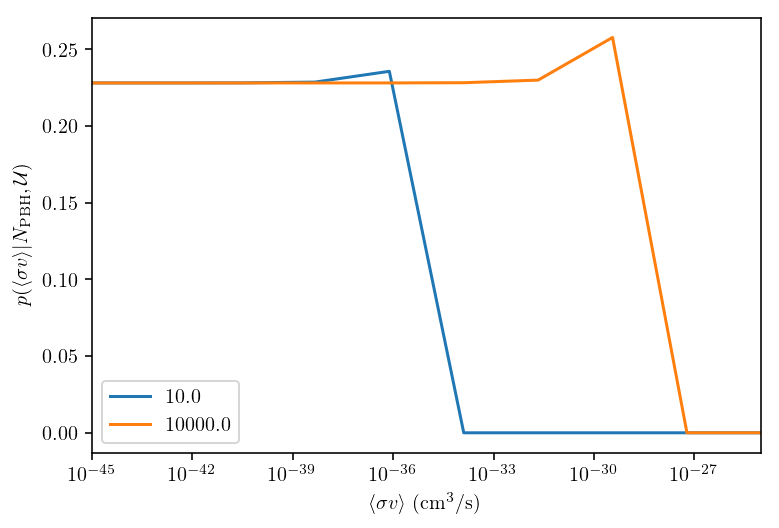

In [29]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[0], label=m_dms[0])
plt.plot(svs, post_vals[-1], label=m_dms[-1])

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.xlim(svs[[0, -1]])
plt.legend()

In [30]:
os.system("say 'Done'")

0

## Loading results generated by the script

In [2]:
m_pbh = 0.7
n_pbh = 1  # number of detected PBHs

m_dms, svs, post_vals = load_posterior(m_pbh, n_pbh)

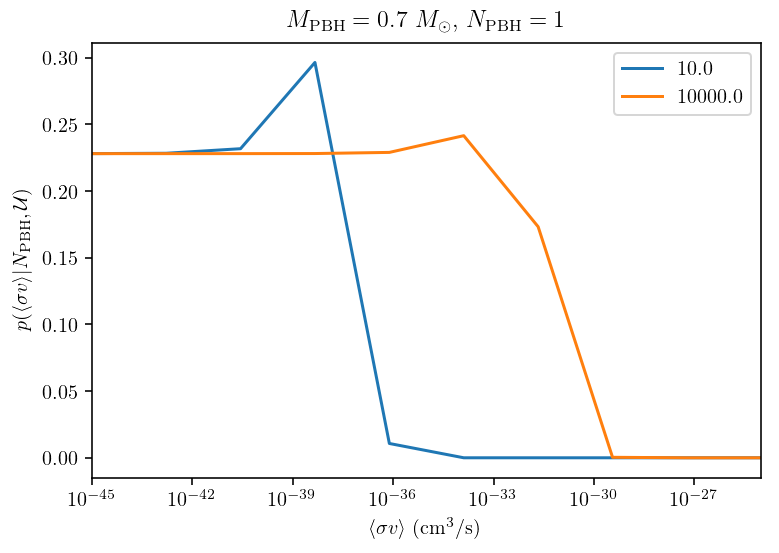

In [3]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[0], label=m_dms[0])
plt.plot(svs, post_vals[-1], label=m_dms[-1])

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = %i$" % (m_pbh, n_pbh), fontsize=12)
plt.xlim(svs[[0, -1]])
plt.legend()

In [ ]:
tqdm.

In [33]:
def fun(x):
    return x**3

tqdm(np.vectorize(fun))(np.linspace(0, 100))

0it [00:00, ?it/s]


TypeError: 'tqdm' object is not callable

# Scratch/development

In [96]:
m_dm_col, sv_col, p_gamma_col = np.loadtxt("data/p_gamma_M=%.1f.csv" % m_pbh).T

p_gammas[i, j] = p_gamma(m_dm[i], sv[j])

In [140]:
m_dms = np.unique(m_dm_col)
svs = np.unique(sv_col)
# m_dm_mg, sv_mg = np.meshgrid(m_dms, svs, indexing="ij", sparse=True)
p_gammas = p_gamma_col.reshape([m_dms.size, svs.size])

In [141]:
def load_p_gamma(m_pbh):
    m_dm_col, sv_col, p_gamma_col = np.loadtxt("data/p_gamma_M=%.1f.csv" % m_pbh).T
    m_dms = np.unique(m_dm_col)
    svs = np.unique(sv_col)
    p_gammas = p_gamma_col.reshape([m_dms.size, svs.size])
    p_gamma_rg = RegularGridInterpolator((m_dms, svs), p_gammas)

    def p_gamma(m_dm, sv):
        # Wrap the interpolator, since its interface is horrible
        m_dm = np.asarray(m_dm)
        sv = np.asarray(sv)

        if m_dm.size > 1 and sv.size > 1:
            return p_gamma_rg(np.array([m_dm, sv]).T)
        elif m_dm.size > 1:
            return p_gamma_rg(np.array([m_dm, sv*np.ones_like(m_dm)]).T)
        elif sv.size > 1:
            return p_gamma_rg(np.array([m_dm*np.ones_like(sv), sv]).T)
        else:
            return p_gamma_rg(np.array([m_dm, sv]))

    return p_gamma

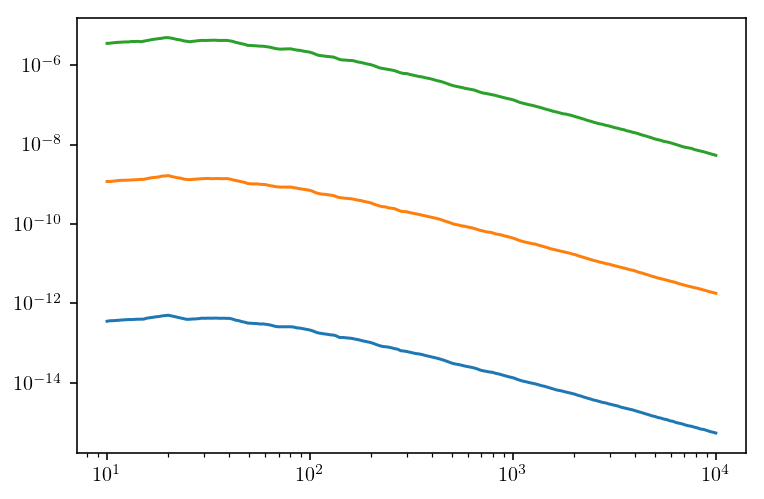

In [149]:
plt.plot(m_dms, p_gamma(m_dms, svs[0]))
plt.plot(m_dms, p_gamma(m_dms, svs[100]))
plt.plot(m_dms, p_gamma(m_dms, svs[-1]))
plt.xscale("log")
plt.yscale("log")

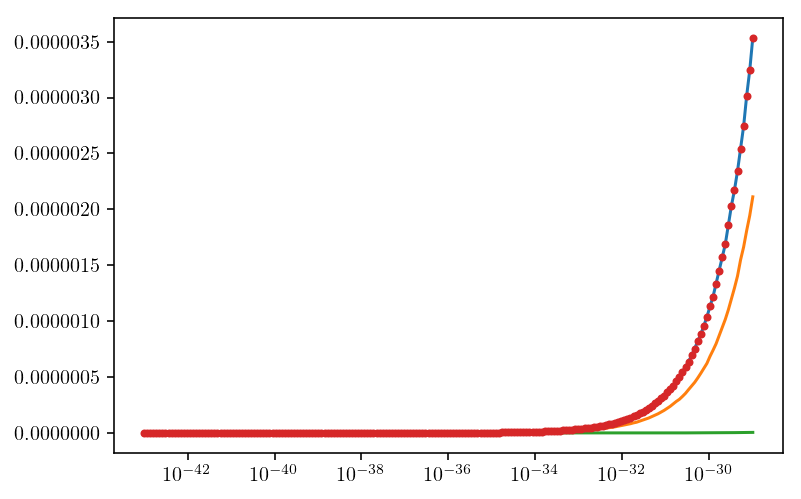

In [145]:
plt.plot(svs, p_gamma(1e1, svs))
plt.plot(svs, p_gamma(1e2, svs))
plt.plot(svs, p_gamma(1e4, svs))
plt.plot(svs, p_gamma_col[:svs.size], '.')
plt.xscale("log")

In [27]:
sv_pts = np.logspace(-43, -29, 100)
p_gamma_pts = get_p_gamma_val(m_pbh, m_dm, sv_pts)
p_gamma = interp1d(sv_pts, p_gamma_pts)

In [24]:
svs = np.logspace(-39, -26, 20)
posterior_vals = []

for sv in svs:
    posterior_vals.append(0)
    for n_gamma in np.arange(0, n_u_0+1, 1):
        posterior_vals[-1] += quad(lambda f: posterior_integrand(sv, n_gamma, f, n_pbh, n_u_0,
                                                                 p_f, p_gamma, m_pbh),
                                   1e-6, 1, epsabs=1e-99)[0]

posterior_vals = np.array(posterior_vals)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if __name__ == '__main__':
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The algorithm does not conver

(1e-39, 1e-26)

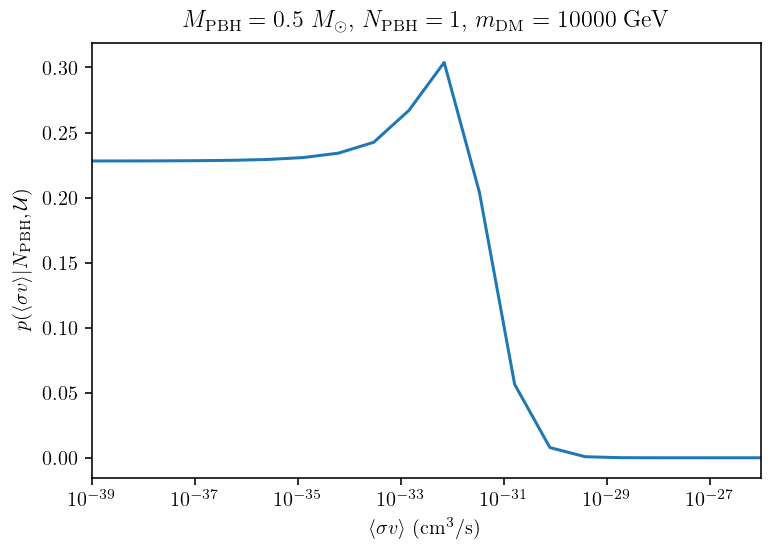

In [25]:
plt.plot(svs, posterior_vals)

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.title((r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = 1$, "
           r"$m_{\mathrm{DM}} = %i$ GeV") % (m_pbh, m_dm), fontsize=12)
plt.xlim(svs[[0, -1]])

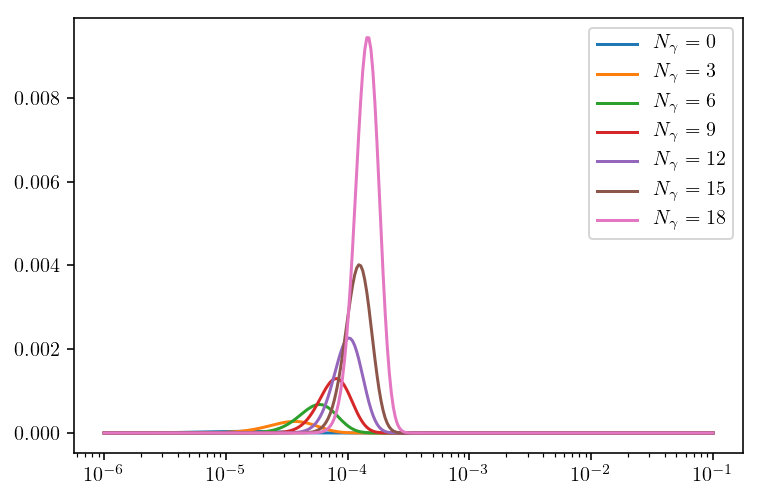

In [58]:
fs = np.logspace(-6, -1, 300)

for n_gamma in np.arange(0, 19, 3):
    plt.plot(fs, posterior_integrand(1e-33, n_gamma, fs, n_pbh, n_u_0, p_f, p_gamma, m_pbh),
             label=r"$N_\gamma=%i$" % n_gamma)

plt.xscale("log")
plt.legend()